# A suggestion of curse changes for a robot sailboat

## Motivation

The goal of this project is to suggest good points to change the curse of a sailboat while going from point $A$ to point $B$.

This project is done as part of the curse "Maschienen Learning" at the University of Applied Sciences South Westphalia. The code labeling the was writen by the team of the [Sailing Team Darmstadt e.V.](https://www.st-darmstadt.de/). A society of stundens whose goal it is to build the ["roBOOTer"](https://www.st-darmstadt.de/ueber-uns/boote/prototyp-ii/) a fully autonomous sailboat able to cross the atlantic ocean. A technical challenge that was mastered the first time only a few years ago by [a Norwegian team](http://sailbuoy.no/). I myself am part of the Sailing Team Darmstadt e.V. for nearly 10 years.

One of the challenges to solve is a highly efficient way to find a path over the Ocean. The boot is only 2 meters long and powered by solar energy. That makes power a relatively spares commodity.

## Situation as is
At the moment the pathfinding algorithm generates a set of more or less random routes to the goal. Each route than gets optimized by a gradient decent moving the curse change points over the ocean to find a path with the lowest cost that can be found by following the highest gradient. This is relatively inefficient since only local minima can be found for each of the randomly generated route. The route with the lowest cost for the so optimized route will be chosen as the final route.
The idea of this project is to ascertain if it is possible to generate a better initial route through a neural network to give the system a kind of good instinct for the initial routes to reduce optimization steps and the number fo routes that need to be calculated to find a good route. Even tough the initial calculation effort could be high the parallel calculation of 40 routes and lots of optimization steps make it possible that some calculation time and therefore energy can be saved this way.
The idea of this project is to ascertain if it is possible to generate a better initial route through a neural network to give the system a kind of good instinct for the initial routes to reduce optimization steps and the number fo routes that need to be calculated to find a good route. Even tough the initial calculation effort could be high the parallel calculation of 40 routes and lots of optimization steps make it possible that some calculation time and energy can be saved this way.

## The Project

The goal of this project is to calculate a good first route. That allows for some simplifications of this problem.

Some solutions and assumptions can be made.
1. The route proposed by this network will not be the final route. This make a somewhat accurate solution good enough.
2. Since the neural network should not learn how to interpret a specific map but the concept of a map the map can be rotated.
This allows the wind to come always from north.
3. Since curse speed is only somewhat proportional to the wind speed a final course may change depending on wind speed not only direction.
These changes are however somewhat small compared to other influences and can hopefully be ignored since later processing of a proposed route should strait these details out.
4. When the wind comes always from the same direction (After map orientation by wind) map and route can be mirrored allowing to use all data twice for each route.
5. Scale does only matter when the curvature of the earth has a significant influence. Allowing for different scaling of the problem for additional training data.

Since there is a solution for this project that only needs some optimisation we can used labeled data to train the network.

### The generell structure

Since

In [382]:
from typing import Optional, Union, Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import ImageDraw, Image
from shapely.geometry import Polygon, Point
from shapely.ops import unary_union

In [383]:
SIZE_INNER = 50
SIZE_ROUTE = 100
MIN_DESTINATION_DISTANCE = 25

In [384]:
# https://stackoverflow.com/questions/16444719/python-numpy-complex-numbers-is-there-a-function-for-polar-to-rectangular-co
def polar_to_cartesian(
    radii: np.ndarray,
    angles: np.ndarray,
):
    """Transforms polar coordinates into cartesian coordinates.

    Args:
        radii: A array of radii.
        angles: A array of angles.

    Returns:
        An array of cartesian coordinates.
    """
    return radii * np.exp(2j * angles * np.pi)


def cartesian_to_polar(
    x: np.ndarray,
):
    """Transforms cartesian coordinates into polar coordinates.

    Args:
        x: A set of complex number to be separated into polar coordinates.

    Returns:
        An distance array and an angle array.
    """
    return abs(x), np.angle(x)

In [385]:
def random_polygon(
    radius_mean: float = 2,
    radius_sigma: float = 1.5,
):
    """Generates the simplest of polygons, a triangle with a size described by a random polygon.

    Args:
        radius_mean: The average radius defining a circumcircle of a triangle.
        radius_sigma: The variance of a radius defining a circumcircle of a triangle.

    Returns:
        A single triangle.
    """
    array = polar_to_cartesian(
        np.random.lognormal(radius_mean, radius_sigma), np.random.rand(3)
    )
    offset = np.random.randint(low=-SIZE_ROUTE, high=SIZE_ROUTE, size=(2,))
    return_values = np.zeros((3, 2), dtype=float)
    # return_values[1, :] = np.real(offset)
    return_values[:] = offset
    return_values[:, :] += np.array((np.real(array), np.imag(array))).T
    return Polygon(return_values)
    # return np.array( + offset[0], np.imag(array) + offset[1])


random_polygon().exterior.xy

(array('d', [7.834251210977271, 48.43780293223563, 22.372740082639517, 7.834251210977271]),
 array('d', [-60.57486395322814, -63.49031084137326, -27.286653804050623, -60.57486395322814]))

In [386]:
print(random_polygon())

POLYGON ((-27.951979105071 -66.53134677013938, -45.511910934378555 -68.64134887839623, -37.309218213928624 -98.84106120532472, -27.951979105071 -66.53134677013938))


In [387]:
def generate_obstacles(
    seed=None,
    number_of_polygons: int = 50,
    radius_mean: float = 2,
    radius_sigma: float = 1,
):
    """Generates a set of obstacles from a union of triangles.

    The union of triangles meas that if polygons overlap o polygon containing the union of those polygons is returned.
    Args:
        seed: A seed to generate a set of obstacles from.
        number_of_polygons: The number of polygons that should be drawn.
        radius_mean: The average radius defining a circumcircle of an obstacle triangle.
        radius_sigma: The variance of a radius defining a circumcircle of an obstacle triangle.

    Returns:
        A list of unified obstacles.
    """
    if seed is not None:
        np.random.seed(seed)
    polygons = []
    for _ in range(number_of_polygons):
        poly = random_polygon(radius_mean, radius_sigma)
        if poly.contains(Point(0, 0)):
            continue
        polygons.append(poly)
    polygon_list = list(unary_union(polygons).geoms)
    return polygon_list

In [390]:
def generate_destination(obstacles: list[Polygon], seed: Optional[int] = None) -> Point:
    """Generates for a map.

    Can be used to generate a valid destination for list of obstacles.
    Args:
        obstacles: A list of obstacles.
        seed: The seed determining the point.

    Returns:
        A goal that should be reached by the ship.
    """
    # sets the seed
    if seed is not None:
        np.random.seed(seed)

    # generates the point
    point: Optional[Point] = None
    while (
        point is None
        or abs(point.x) < MIN_DESTINATION_DISTANCE
        or abs(point.y) < MIN_DESTINATION_DISTANCE
        or any(obstacle.contains(point) for obstacle in obstacles)
    ):
        point = Point(np.random.randint(-SIZE_INNER, SIZE_INNER, size=(2,), dtype=int))
    return point


print(generate_destination(generate_obstacles(42), 42))

POINT (32 36)


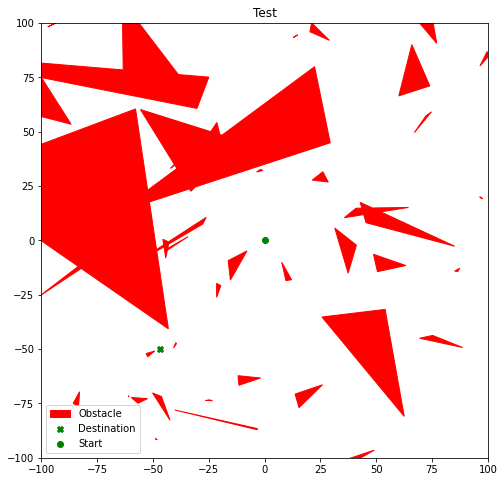

In [419]:
def plot_obstacles(
    obstacles: list[Polygon],
    destination: Optional[Point] = None,
    obstacle_color: Optional[str] = None,
    legend: bool = True,
) -> None:
    """PLots the obstacles into a matplotlib plot.

    Args:
        obstacles: A list of obstacles.
        obstacle_color: The color the obstacles should have. Can be None.
        If none all obstacles will have different colors.
        legend: If true plots a legend.
    Returns:
        None
    """
    plt.figure(figsize=(8, 8))
    plt.axis([-SIZE_ROUTE, SIZE_ROUTE, -SIZE_ROUTE, SIZE_ROUTE])
    plt.title("Test")
    for polygon in obstacles:
        if obstacle_color is not None:
            plt.fill(*polygon.exterior.xy, color=obstacle_color, label="Obstacle")
        else:
            plt.fill(*polygon.exterior.xy)
    plt.scatter(*destination.xy, marker="X", color="green", label="Destination")
    plt.scatter(0, 0, marker="o", color="green", label="Start")
    if legend:
        # https://stackoverflow.com/questions/13588920/stop-matplotlib-repeating-labels-in-legend
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())
    plt.show()


o = generate_obstacles(4)
plot_obstacles(o, generate_destination(o, 4), "RED")

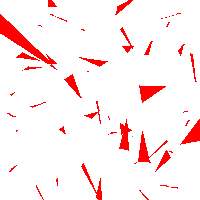

In [391]:
def generate_image_from_map(
    obstacles: list[Polygon], destination: Point, solution
) -> Image:
    """Generate an image from the map.

    Can be used to feed an ANN.
    - Obstacles are marked as reed.
    - The destination is marked as green.
    - The points where the route will likely change are blue.

    Args:
        obstacles: A list of obstacles as shapely Polygons.
        destination: A destination that should be navigated to.
    """
    img = Image.new(
        "RGB",
        (SIZE_ROUTE * 2, SIZE_ROUTE * 2),
        "#ffffff",
    )
    draw = ImageDraw.Draw(img)
    for polygon in obstacles:
        draw.polygon(
            list(np.dstack(polygon.exterior.xy).reshape((-1)) + SIZE_ROUTE),
            fill="#FF0000",
            outline="#FF0000",
        )
    img.putpixel((int(destination.x) + 100, int(destination.y) + 100), (0, 0xFF, 0))
    return img


o = generate_obstacles(42)
g = generate_destination(o, 42)
og_img = generate_image_from_map(o, g, None)
og_img

In [392]:
def generate_all_to_series(
    seed: Optional[int] = None, image: bool = False
) -> pd.Series:
    """Generates everything and aggregates all data into a `pd:Series`.

    Args:
        seed:The seed that should be used to generate map and destination.
        image: If an image should be generated or if that should be postponed to save memory.
    Returns:
        Contains a `pd.Series`containing the following.
        - The seed tha generated the map.
        - The destination in x
        - The destination in y
        - A list of Obstacle polygons.
        - The route generated for this map by the roBOOTer navigation system.
        - Optionally the image containing all the information. Can be generated at a later date without the fear for a loss of accuracy.
    """
    obstacles = generate_obstacles(seed)
    destination = generate_destination(obstacles, seed)

    return pd.Series(
        data={
            "seed": str(seed),
            "obstacles": obstacles,
            "destination_x": destination.x,
            "destination_y": destination.y,
            "image": generate_image_from_map(obstacles, destination, None)
            if image
            else pd.NA,
        }
    )


%timeit generate_all_to_series()

7.15 ms ± 166 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [393]:
%timeit pd.DataFrame([generate_all_to_series(i) for i in range(1000)]).set_index("seed")
df = pd.DataFrame([generate_all_to_series(i) for i in range(1000)]).set_index("seed")
df.to_pickle("test.pickle")
df

7.04 s ± 129 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


obstacles  destination_x  \
seed                                                                     
0     [POLYGON ((-93.57082194649087 -66.947987633875...           -6.0   
1     [POLYGON ((-81.7284773501737 -78.1366517664776...          -13.0   
2     [POLYGON ((-84.97456253498679 -96.322348952267...          -10.0   
3     [POLYGON ((-72.52222134370759 -84.370870527173...          -26.0   
4     [POLYGON ((-49.01395292839513 -91.236864062937...           -4.0   
...                                                 ...            ...   
995   [POLYGON ((-51.07604481480806 -110.26281808589...          -41.0   
996   [POLYGON ((-73.53136121570428 -96.869509434739...           28.0   
997   [POLYGON ((-40.84353887456576 -93.533626866125...           20.0   
998   [POLYGON ((-103.97610620795356 -105.6733356239...           45.0   
999   [POLYGON ((-63.84493689800847 -95.735428561017...           14.0   

      destination_y image  
seed                       
0              -3.0  <NA>  
1             -38.0  <NA>  
2             -35.0  <NA>  
3             -47.0  <NA>  
4               5.0  <NA>  
...             ...   ...  
995           -20.0  <NA>  
996            39.0  <NA>  
997           -41.0  <NA>  
998           -12.0  <NA>  
999            42.0  <NA>  

[1000 rows x 4 columns]

In [395]:
df2 = pd.read_pickle("test.pickle")
df2

obstacles  destination_x  \
seed                                                                     
0     [POLYGON ((-93.57082194649087 -66.947987633875...           -6.0   
1     [POLYGON ((-81.7284773501737 -78.1366517664776...          -13.0   
2     [POLYGON ((-84.97456253498679 -96.322348952267...          -10.0   
3     [POLYGON ((-72.52222134370759 -84.370870527173...          -26.0   
4     [POLYGON ((-49.01395292839513 -91.236864062937...           -4.0   
...                                                 ...            ...   
995   [POLYGON ((-51.07604481480806 -110.26281808589...          -41.0   
996   [POLYGON ((-73.53136121570428 -96.869509434739...           28.0   
997   [POLYGON ((-40.84353887456576 -93.533626866125...           20.0   
998   [POLYGON ((-103.97610620795356 -105.6733356239...           45.0   
999   [POLYGON ((-63.84493689800847 -95.735428561017...           14.0   

      destination_y image  
seed                       
0              -3.0  <NA>  
1             -38.0  <NA>  
2             -35.0  <NA>  
3             -47.0  <NA>  
4               5.0  <NA>  
...             ...   ...  
995           -20.0  <NA>  
996            39.0  <NA>  
997           -41.0  <NA>  
998           -12.0  <NA>  
999            42.0  <NA>  

[1000 rows x 4 columns]

https://programtalk.com/python-examples/PIL.ImageDraw.Draw.polygon/)
https://stackoverflow.com/questions/3654289/scipy-create-2d-polygon-mask